<a href="https://colab.research.google.com/github/divya-r-kamat/NLP-With-PyTorch/blob/master/TextSegmentation/Article_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Segmentation

Implementation from [Text Segmentation as a Supervised Learning Task](https://arxiv.org/pdf/1803.09337v1.pdf)



In [1]:
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import gensim
from torch.utils.data import Dataset
from __future__ import print_function
from pathlib import Path
import math

from nltk.tokenize import RegexpTokenizer
import nltk.data
import numpy as np

In [2]:
train_path="/content/drive/My Drive/text-segmentation/data/Dataset/training-data"
test_path="/content/drive/My Drive/text-segmentation/data/Dataset/test-data"
valid_path="/content/drive/My Drive/text-segmentation/data/Dataset/val-data"

In [3]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/My Drive/text-segmentation/data/word2vec/GoogleNews-vectors-negative300.bin", binary=True)

In [4]:
def clean_paragraph(paragraph):
    cleaned_paragraph= paragraph.replace("'' ", " ").replace(" 's", "'s").replace("``", "").strip('\n')
    return cleaned_paragraph


sentence_tokenizer = None
words_tokenizer = None


def get_punkt():
    global sentence_tokenizer
    if sentence_tokenizer:
        return sentence_tokenizer

    #try:
    nltk.download('punkt')
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    #except exceptions.LookupError:
        #nltk.download('punkt')
        #tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

    sentence_tokenizer = tokenizer
    return sentence_tokenizer

def get_words_tokenizer():
    global words_tokenizer

    if words_tokenizer:
        return words_tokenizer

    words_tokenizer = RegexpTokenizer(r'\w+')
    return words_tokenizer

def extract_sentence_words(sentence, remove_missing_emb_words = False,remove_special_tokens = False):
    if (remove_special_tokens):
        for token in wiki_utils.get_special_tokens():
            # Can't do on sentence words because tokenizer delete '***' of tokens.
            sentence = sentence.replace(token, "")
    tokenizer = get_words_tokenizer()
    sentence_words = tokenizer.tokenize(sentence)
    if remove_missing_emb_words:
        sentence_words = [w for w in sentence_words if w not in missing_stop_words]

    return sentence_words

def word_model(word, model):
    if model is None:
        return np.random.randn(1, 300)
    else:
        if word in model:
            return model[word].reshape(1, 300)
        else:
            #print ('Word missing w2v: ' + word)
            return model['UNK'].reshape(1, 300)


def get_list_token():
    return "***LIST***"

def split_sentence_with_list(sentence):
    list_pattern = "\n" + get_list_token() + "."
    if sentence.endswith( list_pattern ):
        #splited_sentence = [str for str in sentence.encode('utf-8').split("\n" + wiki_utils.get_list_token() + ".") if len(str) > 0]
        splited_sentence = [str for str in sentence.split("\n" + get_list_token() + ".") if
                            len(str) > 0]
        splited_sentence.append(get_list_token() + ".")
        return splited_sentence
    else:
        return [sentence]

def split_sentece_colon_new_line(sentence):

    splited_sentence = sentence.split(":\n")
    if (len(splited_sentence) == 1):
        return splited_sentence
    new_sentences = []
    # -1 . not to add ":" to last sentence
    for i in range(len(splited_sentence) - 1):
        if (len(splited_sentence[i]) > 0):
            new_sentences.append(splited_sentence[i] + ":")
    if (len(splited_sentence[-1]) > 0):
        new_sentences.append(splited_sentence[-1])
    return new_sentences

def split_long_sentences_with_backslash_n(max_words_in_sentence,sentences, doc_id):
    new_sentences = []
    for sentence in sentences:
        sentence_words = extract_sentence_words(sentence)
        if len(sentence_words) > max_words_in_sentence:
            splitted_sentences = sentence.split('\n')
            if len(splitted_sentences) > 1:
                logger.info("Sentence with backslash was splitted. Doc Id: " + str(doc_id) +"   Sentence:  " + sentence)
            new_sentences.extend(splitted_sentences )
        else:
            if "\n" in sentence:
                logger.info("No split for sentence with backslash n. Doc Id: " + str(doc_id) +"   Sentence:  " + sentence)
            new_sentences.append(sentence)
    return new_sentences

def split_sentences(text, doc_id):
    sentences = get_punkt().tokenize(text)
    senteces_list_fix = []
    for sentence in sentences:
        seplited_list_sentence = split_sentence_with_list(sentence)
        senteces_list_fix.extend(seplited_list_sentence)

    sentence_colon_fix = []
    for sentence in senteces_list_fix:
        splitted_colon_sentence =  split_sentece_colon_new_line(sentence)
        sentence_colon_fix.extend(splitted_colon_sentence)
    max_words_in_sentence_with_backslash_n=45
    sentences_without_backslash_n = split_long_sentences_with_backslash_n(max_words_in_sentence_with_backslash_n, sentence_colon_fix, doc_id)

    ret_sentences = []
    for sentence in sentences_without_backslash_n:
        ret_sentences.append(sentence.replace('\n',' '))


    return ret_sentences

In [5]:
def read_choi_file(path, word2vec, return_w2v_tensors = True):
    # seperator = '=========='
    seperator =  '-----'
    with Path(path).open('r') as f:
        raw_text = f.read()
    paragraphs = [clean_paragraph(p) for p in raw_text.strip().split(seperator)
                  if len(p) > 5 and p != "\n"]

    targets = []
    new_text = []
    lastparagraphsentenceidx = 0

    for paragraph in paragraphs:
        file_id = str(path).split('/')[-1:][0]
        sentences = split_sentences(paragraph,file_id)

        if sentences:
            sentences_count =0
            # This is the number of sentences in the paragraph and where we need to split.
            for sentence in sentences:
                words = extract_sentence_words(sentence)
                if (len(words) == 0):
                    continue
                sentences_count +=1
                if return_w2v_tensors:
                    new_text.append([word_model(w, word2vec) for w in words])
                else:
                    new_text.append(words)

            lastparagraphsentenceidx += sentences_count
            targets.append(lastparagraphsentenceidx - 1)

    return new_text, targets, path

In [6]:
class ChoiDataset(Dataset):
    def __init__(self, root, word2vec):
        self.textfiles = list(Path(root).glob('**/*.txt'))

        if len(self.textfiles) == 0:
            raise RuntimeError('Found 0 files in subfolders of: {}'.format(root))
        self.root = root
        self.word2vec = word2vec

    def __getitem__(self, index):
        path = self.textfiles[index]

        return read_choi_file(path, self.word2vec)

    def __len__(self):
        return len(self.textfiles)


In [7]:
train_dataset = ChoiDataset(train_path, word2vec)
valid_dataset = ChoiDataset(valid_path, word2vec)

test_dataset = ChoiDataset(test_path, word2vec)

In [8]:
len(train_dataset)

2234

In [9]:
train_dataset[1]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


([[array([[-0.17285156,  0.27929688,  0.10693359, -0.15820312, -0.08447266,
            0.05908203,  0.04077148,  0.00254822,  0.25976562,  0.18066406,
            0.09765625, -0.08105469, -0.01049805,  0.09814453,  0.00060272,
            0.07080078, -0.015625  , -0.09521484, -0.08105469, -0.02868652,
           -0.03320312,  0.16503906,  0.03979492, -0.03710938,  0.04101562,
           -0.12695312, -0.12890625,  0.12353516,  0.04980469,  0.01257324,
            0.05786133, -0.00830078, -0.02832031, -0.03320312,  0.16113281,
            0.07519531, -0.25976562,  0.08935547,  0.13574219,  0.00460815,
           -0.04418945,  0.02319336, -0.10449219, -0.05151367,  0.08349609,
           -0.02050781, -0.02172852, -0.02734375,  0.16015625,  0.19042969,
           -0.0324707 ,  0.06787109,  0.10302734, -0.25390625,  0.00634766,
            0.20507812,  0.02111816, -0.21679688, -0.02441406,  0.17089844,
           -0.21875   ,  0.10009766, -0.15527344, -0.12597656, -0.03833008,
           -

In [10]:
valid_dataset[0]


([[array([[-0.10107422, -0.01538086,  0.21582031, -0.17382812, -0.01452637,
            0.01696777, -0.40820312,  0.18652344, -0.28515625,  0.15039062,
           -0.04345703,  0.06445312, -0.34960938, -0.00582886,  0.00674438,
           -0.24414062,  0.22851562,  0.10253906, -0.03564453, -0.06396484,
           -0.11621094,  0.04418945,  0.09179688,  0.00086975, -0.30664062,
           -0.06005859,  0.07666016,  0.64453125,  0.24511719,  0.05908203,
           -0.05615234,  0.21679688, -0.24121094, -0.26367188,  0.0300293 ,
           -0.01324463, -0.02844238, -0.13085938,  0.0402832 ,  0.05810547,
           -0.24511719, -0.43554688, -0.3203125 ,  0.0177002 ,  0.10107422,
           -0.16210938, -0.078125  ,  0.33789062,  0.02368164,  0.06982422,
           -0.13476562,  0.22949219,  0.09375   ,  0.0267334 , -0.12792969,
            0.04907227, -0.21679688, -0.19042969,  0.05151367,  0.27734375,
           -0.23535156,  0.06054688, -0.20605469,  0.10888672,  0.06152344,
           -

In [11]:
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    batched_data = []
    batched_targets = []
    paths = []

    window_size = 1
    before_sentence_count = int(math.ceil(float(window_size - 1) /2))
    after_sentence_count = window_size - before_sentence_count - 1

    for data, targets, path in batch:
        try:
            max_index = len(data)
            tensored_data = []
            for curr_sentence_index in range(0, len(data)):
                from_index = max([0, curr_sentence_index - before_sentence_count])
                to_index = min([curr_sentence_index + after_sentence_count + 1, max_index])
                sentences_window = [word for sentence in data[from_index:to_index] for word in sentence]
                tensored_data.append(torch.FloatTensor(np.concatenate(sentences_window)))

            #Create one hot encoding for the targets
            tensored_targets = torch.zeros(len(data)).long()
            tensored_targets[torch.LongTensor(targets)] = 1
            tensored_targets = tensored_targets[:-1]


            batched_data.append(tensored_data)
            batched_targets.append(tensored_targets)
            paths.append(path)

        except Exception as e:
            logger.info('Exception "%s" in file: "%s"', e, path)
            logger.debug('Exception!', exc_info=True)
            continue
      

    return batched_data, batched_targets, paths

In [12]:
train_dl = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True,
                              num_workers=2)
valid_dl = DataLoader(valid_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False,
                            num_workers=2)

In [13]:
for i,batch in enumerate(train_dl):
  print(batch)
  break

([[tensor([[-0.1729,  0.2793,  0.1069,  ...,  0.1230,  0.1299, -0.1826],
        [-0.0464,  0.0242, -0.3633,  ..., -0.1826,  0.2373, -0.0150],
        [ 0.0151,  0.0977, -0.0459,  ...,  0.1289,  0.0903, -0.1299],
        ...,
        [-0.0245, -0.0305, -0.1240,  ...,  0.2100,  0.0233, -0.2012],
        [ 0.2256, -0.1406,  0.0967,  ..., -0.0830,  0.1689,  0.0250],
        [-0.0091, -0.0442,  0.0996,  ...,  0.1445,  0.1807, -0.0869]]), tensor([[-0.1855,  0.3223,  0.2520,  ..., -0.1367,  0.1621, -0.0771],
        [ 0.1226, -0.0065,  0.0625,  ...,  0.0413, -0.0488, -0.0205],
        [-0.0947, -0.5117,  0.0581,  ...,  0.3906, -0.0034,  0.2812],
        ...,
        [-0.0315,  0.0645, -0.0605,  ...,  0.0388,  0.1523, -0.0269],
        [ 0.0270, -0.2002,  0.0232,  ..., -0.0530,  0.2451,  0.0625],
        [-0.0630, -0.0041, -0.0786,  ...,  0.0581,  0.0723, -0.1245]]), tensor([[-0.2891,  0.3262,  0.1895,  ...,  0.1377,  0.0938, -0.1592],
        [-0.0967, -0.0264,  0.0903,  ..., -0.0197,  0.213

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def unsort(sort_order):
    result = [-1] * len(sort_order)

    for i, index in enumerate(sort_order):
        result[index] = i

    return result

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# from utils import maybe_cuda, setup_logger, unsort
import numpy as np
# from times_profiler import profiler


def zero_state(module, batch_size):
    # * 2 is for the two directions
    return Variable(torch.zeros(module.num_layers * 2, batch_size, module.hidden)).to(device), \
           Variable(torch.zeros(module.num_layers * 2, batch_size, module.hidden)).to(device)


class SentenceEncodingRNN(nn.Module):
    def __init__(self, input_size, hidden, num_layers):
        super(SentenceEncodingRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden = hidden
        self.input_size = input_size

        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden,
                            num_layers=self.num_layers,
                            dropout=0.1,
                            bidirectional=True)

    def forward(self, x):
        batch_size = x.batch_sizes[0]
        s = zero_state(self, batch_size)
        packed_output, _ = self.lstm(x, s)
        padded_output, lengths = pad_packed_sequence(packed_output) # (max sentence len, batch, 256) 

        maxes = Variable(torch.zeros(batch_size, padded_output.size(2))).to(device)
        for i in range(batch_size):
            maxes[i, :] = torch.max(padded_output[:lengths[i], i, :], 0)[0]

        return maxes


class Model(nn.Module):
    def __init__(self, sentence_encoder, hidden=128, num_layers=2):
        super(Model, self).__init__()

        self.sentence_encoder = sentence_encoder

        self.sentence_lstm = nn.LSTM(input_size=sentence_encoder.hidden * 2,
                                     hidden_size=hidden,
                                     num_layers=num_layers,
                                     batch_first=True,
                                     dropout=0.2,
                                     bidirectional=True)

        # We have two labels
        self.h2s = nn.Linear(hidden * 2, 2)

        self.num_layers = num_layers
        self.hidden = hidden

        # self.criterion = nn.CrossEntropyLoss()


    def pad(self, s, max_length):
        s_length = s.size()[0]
        v = Variable(s.unsqueeze(0).unsqueeze(0)).to(device)
        padded = F.pad(v, (0, 0, 0, max_length - s_length))  # (1, 1, max_length, 300)
        shape = padded.size()
        return padded.view(shape[2], 1, shape[3])  # (max_length, 1, 300)


    def pad_document(self, d, max_document_length):
        d_length = d.size()[0]
        v = d.unsqueeze(0).unsqueeze(0)
        padded = F.pad(v, (0, 0,0, max_document_length - d_length ))  # (1, 1, max_length, 300)
        shape = padded.size()
        return padded.view(shape[2], 1, shape[3])  # (max_length, 1, 300)

    def forward(self, batch):
        batch_size = len(batch)

        sentences_per_doc = []
        all_batch_sentences = []
        for document in batch:
            all_batch_sentences.extend(document)
            sentences_per_doc.append(len(document))

        #Get the length of each sentences in the batch
        lengths = [s.size()[0] for s in all_batch_sentences]

        #sort in descending order
        sort_order = np.argsort(lengths)[::-1]
        sorted_sentences = [all_batch_sentences[i] for i in sort_order]
        sorted_lengths = [s.size()[0] for s in sorted_sentences]

        #get the maximum length
        max_length = max(lengths)

        #pad the sentences with the maximum length
        padded_sentences = [self.pad(s, max_length) for s in sorted_sentences]
        big_tensor = torch.cat(padded_sentences, 1)  # (max_length, batch size, 300)

        #pack padd the sequence so that the padded vectors are not considered for backpropogation
        packed_tensor = pack_padded_sequence(big_tensor, sorted_lengths)
        encoded_sentences = self.sentence_encoder(packed_tensor)
        unsort_order = Variable(torch.LongTensor(unsort(sort_order))).to(device)
        unsorted_encodings = encoded_sentences.index_select(0, unsort_order)

        index = 0
        encoded_documents = []
        for sentences_count in sentences_per_doc:
            end_index = index + sentences_count
            encoded_documents.append(unsorted_encodings[index : end_index, :])
            index = end_index

        doc_sizes = [doc.size()[0] for doc in encoded_documents]
        max_doc_size = np.max(doc_sizes)
        ordered_document_idx = np.argsort(doc_sizes)[::-1]
        ordered_doc_sizes = sorted(doc_sizes)[::-1]
        ordered_documents = [encoded_documents[idx] for idx in ordered_document_idx]
        padded_docs = [self.pad_document(d, max_doc_size) for d in ordered_documents]
        docs_tensor = torch.cat(padded_docs, 1)
        packed_docs = pack_padded_sequence(docs_tensor, ordered_doc_sizes)
        sentence_lstm_output, _ = self.sentence_lstm(packed_docs, zero_state(self, batch_size=batch_size))
        padded_x, _ = pad_packed_sequence(sentence_lstm_output)  # (max sentence len, batch, 256)

        doc_outputs = []
        for i, doc_len in enumerate(ordered_doc_sizes):
            doc_outputs.append(padded_x[0:doc_len - 1, i, :])  # -1 to remove last prediction

        unsorted_doc_outputs = [doc_outputs[i] for i in unsort(ordered_document_idx)]
        sentence_outputs = torch.cat(unsorted_doc_outputs, 0)

        x = self.h2s(sentence_outputs)
        return x

In [17]:
sentence_encoder = SentenceEncodingRNN(input_size=300,hidden=256,num_layers=2)
model = Model(sentence_encoder, hidden=256, num_layers=2)

In [18]:
model

Model(
  (sentence_encoder): SentenceEncodingRNN(
    (lstm): LSTM(300, 256, num_layers=2, dropout=0.1, bidirectional=True)
  )
  (sentence_lstm): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (h2s): Linear(in_features=512, out_features=2, bias=True)
)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,874,690 trainable parameters


In [20]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [21]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [22]:
def train(model, iterator, optimizer, criterion):
    model.train()
    
    epoch_loss = 0
    
    for i,  (data, target, paths) in enumerate(iterator):
        optimizer.zero_grad()
        output = model(data)
        target_var = Variable(torch.cat(target, 0).to(device), requires_grad=False)
        loss = criterion(output, target_var)
        loss.backward()        
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
      for i,  (data, target, paths) in enumerate(iterator):
        optimizer.zero_grad()
        output = model(data)
        target_var = Variable(torch.cat(target, 0).to(device), requires_grad=False)
        loss = criterion(output, target_var)
        epoch_loss += loss.item()

        predictions.append(output.detach().cpu().numpy().argmax(axis=1))
        true_labels.append(target_var.detach().cpu().numpy())
    
    predictions = np.hstack(predictions)
    true_labels = np.hstack(true_labels)


    return epoch_loss / len(iterator), predictions, true_labels

In [24]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
from sklearn.metrics import f1_score

N_EPOCHS = 10
train_loss_values = []
valid_loss_values = []

predictions = []
true_labels = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_dl, optimizer, criterion)
    valid_loss, y_pred, y_true = evaluate(model, valid_dl, criterion)

    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)

    f1 = f1_score(y_true, y_pred, average='micro')

    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | F1 Score : {f1:.3f}')

Epoch: 01 | Time: 4m 40s
	Train Loss: 0.519 | Train PPL:   1.681
	 Val. Loss: 0.445 |  Val. PPL:   1.561 | F1 Score : 0.774
Epoch: 02 | Time: 4m 36s
	Train Loss: 0.402 | Train PPL:   1.496
	 Val. Loss: 0.376 |  Val. PPL:   1.456 | F1 Score : 0.811
Epoch: 03 | Time: 4m 35s
	Train Loss: 0.349 | Train PPL:   1.418
	 Val. Loss: 0.329 |  Val. PPL:   1.390 | F1 Score : 0.850
Epoch: 04 | Time: 4m 42s
	Train Loss: 0.318 | Train PPL:   1.374
	 Val. Loss: 0.330 |  Val. PPL:   1.391 | F1 Score : 0.850
Epoch: 05 | Time: 4m 42s
	Train Loss: 0.289 | Train PPL:   1.335
	 Val. Loss: 0.295 |  Val. PPL:   1.343 | F1 Score : 0.877
Epoch: 06 | Time: 4m 33s
	Train Loss: 0.270 | Train PPL:   1.309
	 Val. Loss: 0.290 |  Val. PPL:   1.337 | F1 Score : 0.875
Epoch: 07 | Time: 4m 34s
	Train Loss: 0.249 | Train PPL:   1.283
	 Val. Loss: 0.283 |  Val. PPL:   1.327 | F1 Score : 0.882
Epoch: 08 | Time: 4m 36s
	Train Loss: 0.230 | Train PPL:   1.259
	 Val. Loss: 0.297 |  Val. PPL:   1.346 | F1 Score : 0.871
Epoch: 0

In [32]:
print(y_true)

[1 0 1 ... 1 0 0]


In [33]:
print(y_pred)

[1 0 1 ... 1 0 0]


In [34]:
f1

0.8542024013722127

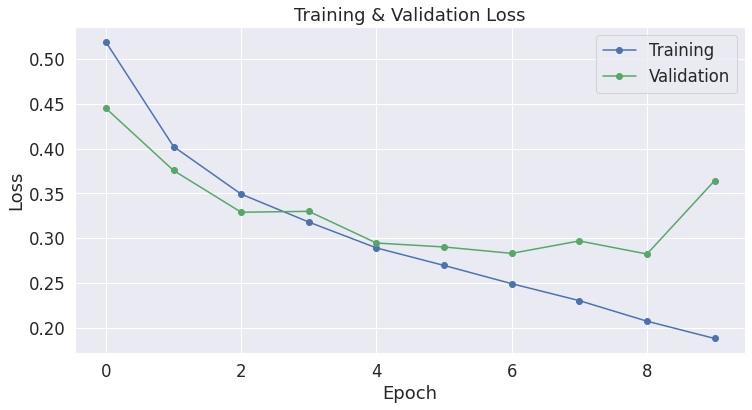

In [35]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(np.array(train_loss_values), 'b-o', label="Training")
plt.plot(np.array(valid_loss_values), 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.xticks([1, 2, 3, 4])

plt.show()

# Inference

In [36]:
def prepare_tensor(sentences):
    tensored_data = []
    for sentence in sentences:
        if len(sentence) > 0:
            tensored_data.append(torch.FloatTensor(np.concatenate(sentence)).to(device))

    return tensored_data



def text_to_word2vec(sentences, word2vec):
    new_text = []
    for sentence in sentences:
        words = extract_sentence_words(sentence)
        new_text.append([word_model(w, word2vec) for w in words])

    return new_text


def predict_cutoffs(sentences, model, word2vec):
    word2vec_sentences = text_to_word2vec(sentences, word2vec)
    tensored_data = prepare_tensor(word2vec_sentences)
    batched_tensored_data = []
    batched_tensored_data.append(tensored_data)
    output = model(batched_tensored_data)
    values, argmax = output.max(1)
    argmax = argmax.data.cpu().numpy()
    return argmax

In [37]:
def preprocess_text(text, word2vec, return_w2v_tensors = True):
    seperator =  '-----'
    paragraphs = [clean_paragraph(p) for p in text.strip().split(seperator)
                  if len(p) > 5 and p != "\n"]

    targets = []
    new_text = []
    lastparagraphsentenceidx = 0

    for paragraph in paragraphs:
        file_id=0
        sentences = split_sentences(paragraph,file_id)

        if sentences:
            sentences_count =0
            # This is the number of sentences in the paragraph and where we need to split.
            for sentence in sentences:
                words = extract_sentence_words(sentence)
                if (len(words) == 0):
                    continue
                sentences_count +=1
                if return_w2v_tensors:
                    new_text.append([word_model(w, word2vec) for w in words])
                else:
                    new_text.append(words)

            lastparagraphsentenceidx += sentences_count
            targets.append(lastparagraphsentenceidx - 1)

    return new_text, targets

In [38]:
goldset_delimiter = "********"
section_delimiter = "========"

def segment(path, model, word2vec):
    splited_sentences, target = preprocess_text(path, word2vec,False)

    sentences = [' '.join(s) for s in splited_sentences]
    print('...\n sentences...\n')
    print(sentences)
    gold_set = np.zeros(len(splited_sentences)).astype(int)
    gold_set[np.asarray(target)] = 1



    cutoffs = predict_cutoffs(sentences, model, word2vec)
    total = []
    segment = []
    for i, (sentence, cutoff) in enumerate(zip(sentences, cutoffs)):
        segment.append(sentence)
        if cutoff or gold_set[i] == 1:
            full_segment ='. '.join(segment) + '. '
            if cutoff:
                full_segment = full_segment + '\n' + section_delimiter + '\n'
                if gold_set[i] == 1:
                    full_segment = full_segment + goldset_delimiter + '\n'
            else:
                full_segment = full_segment + '\n' +  goldset_delimiter + '\n'
            total.append(full_segment)
            segment = []



    # Model does not return prediction for last sentence
    segment.append(sentences[-1:][0])
    total.append('. '.join(segment))

    output_file_content = "".join(total)
    print(output_file_content)


In [39]:
# import glob
# for filename in glob.glob(test_path + '**/*.txt'):
#    segment(filename, model, word2vec)


In [40]:
text = """NEW YORK: A New York Times columnist on Thursday sold one of his articles in digital form for $563,000, the latest example of the craze surrounding "non fungible tokens," which collectors are snapping up.Keven Roose's article entitled "Buy This Column on the Blockchain" was itself aimed at trying to test the market as to what sort of items would sell in the form of an "NFT."
A non-fungible token (NFT) is a digital object, such as a drawing, piece of music, photo, or video, with a certificate of authenticity created by blockchain technology.This authentication by a network of computers is considered inviolable.The virtual object, which is actually a computer file, can be exchanged or sold with its certificate.
NFTs have become popular in the past six months, as wealthy collectors turn to the digital market during the pandemic.

On Monday, the first message ever posted on Twitter sold for $2.9 million when its sender, Twitter co-founder and chief Jack Dorsey, accepted the winning bid at auction.Earlier this month, a digital collage by American artist Beeple sold for $69.3 million at Christie's, setting a new record for an NFT. 
"Why can't a journalist join the NFT party, too?" asked Roose in his column.At the end of the 24-hour auction, a collector calling himself Farzin won the article with 350 Ethereum, a major cryptocurrency, worth $563,000."Fully just staring at my monitor laughing uncontrollably," Roose, a tech columnist, wrote on Twitter after the sale.
Roose had indicated that the proceeds, after the 15 percent fee deducted by the Foundation platform on which the auction was organized, would go to charities supported by The New York Times."""

In [41]:
segment(text, model, word2vec)

...
 sentences...

['NEW YORK A New York Times columnist on Thursday sold one of his articles in digital form for 563 000 the latest example of the craze surrounding non fungible tokens which collectors are snapping up Keven Roose s article entitled Buy This Column on the Blockchain was itself aimed at trying to test the market as to what sort of items would sell in the form of an NFT', 'A non fungible token NFT is a digital object such as a drawing piece of music photo or video with a certificate of authenticity created by blockchain technology This authentication by a network of computers is considered inviolable The virtual object which is actually a computer file can be exchanged or sold with its certificate', 'NFTs have become popular in the past six months as wealthy collectors turn to the digital market during the pandemic', 'On Monday the first message ever posted on Twitter sold for 2 9 million when its sender Twitter co founder and chief Jack Dorsey accepted the winning bid a